# CNN - Convolutional Neural Network
> This is a tutorial of image classification using CNN (convolutional dataset)

> In this blog we will be using a CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Our objective is to achieve the best accuracy

> The dataset has a total of 60000 images belonging to the following classes 'plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/MNIST.png

![](my_icons/CNN.png)

In [1]:
import torch
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import tarfile
import yaml
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 150

# Defining the datasets and dataloaders
> Spliting the dataset into train, validation and test

> Our objective is to be able to classify these images well

In [3]:
#collapse-output

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transforms.ToTensor())

# spltting the training - validation and test set
random_seed = 42
torch.manual_seed(random_seed)
train_dataset,val_dataset = random_split(train_dataset,[45000,5000])

# Defining the train - val - test dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

#Classes of labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Function to plot the image

In [31]:
def imshow(image):
    #img = img / 2 + 0.5  # unnormalize
    img,label = image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# We can also create a grid of images in-order to understand the dataset

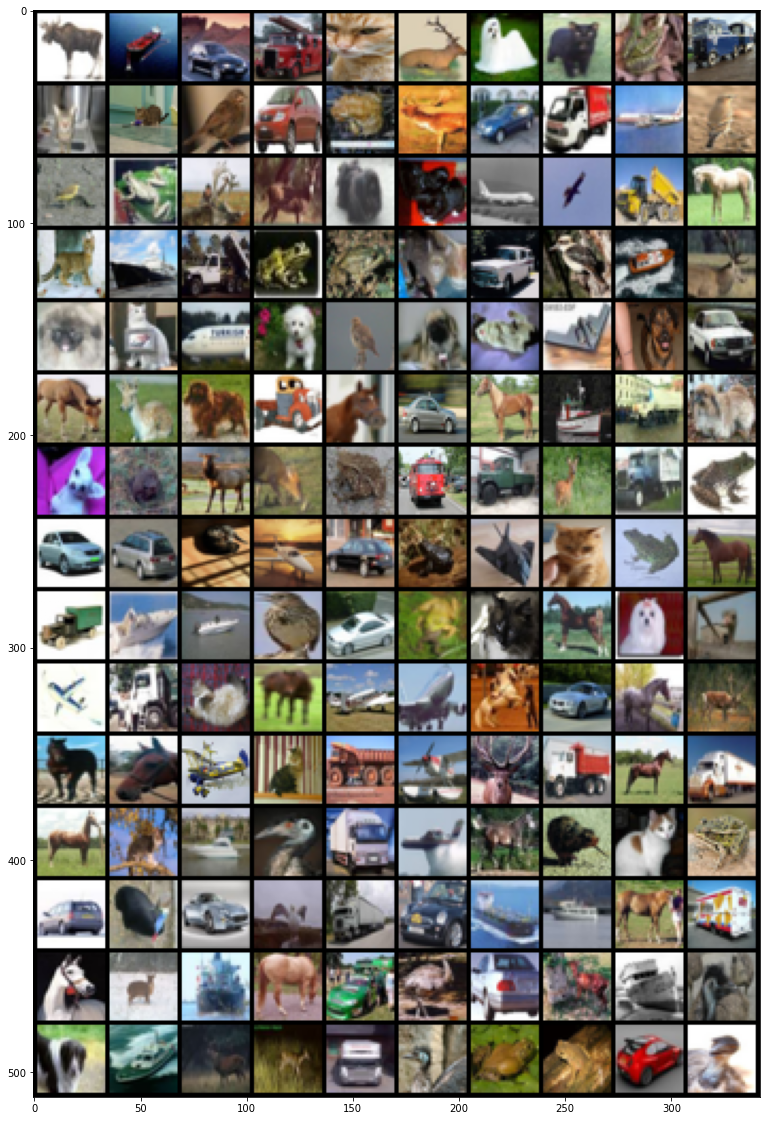

In [10]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
fig, ax = plt.subplots(figsize=(20, 20))
imshow(torchvision.utils.make_grid(images,nrow=10))

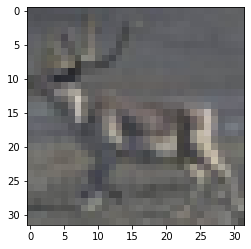

In [12]:
#collapse-output
plt.imshow(train_dataset[30][0].permute(1, 2, 0) );

In [20]:
# Creating the dataloader
train_loader = DataLoader(train_dataset,batch_size=100,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=100,shuffle = True)

# Steps of a CNN
> Convolutions - The process involves the kernel performing element wise multiplication with the input it is currently on and the kernel slides

> Max pooling - Decreases the dimension of the output tensor

> Results from a max pooling layer is then sent to a feed forward neural network

In [14]:
layer1 = nn.Conv2d(3,62,5)
pooling = nn.MaxPool2d(2,2)
layer2 = nn.Conv2d(62,128,5)
layer3 = nn.Conv2d(128,128,5)

In [15]:
for batch,label in train_loader:
    print(batch.shape, label.shape)
    dta = layer1(batch)
    print(dta.shape)
    dta = pooling(dta)
    print(dta.shape)
    dta = layer2(dta)
    print(dta.shape)
    dta = pooling(dta)
    print(dta.shape)
    break

torch.Size([8, 3, 32, 32]) torch.Size([8])
torch.Size([8, 62, 28, 28])
torch.Size([8, 62, 14, 14])
torch.Size([8, 128, 10, 10])
torch.Size([8, 128, 5, 5])


In [16]:
#Model
class convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,62,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(62,128,5)
        self.linear1 = nn.Linear(128*5*5, 140)
        self.linear2 = nn.Linear(140,80)
        self.linear3 = nn.Linear(80,10)
         
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1,128*5*5)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return x

In [17]:
def metric_acc(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def results_epoch(out_lst):
    val_loss_epoch = torch.stack([dct['val_loss'] for dct in out_lst]).mean()
    val_acc_epoch = torch.stack([dct['val_acc'] for dct in out_lst]).mean()
    return {'val_loss': val_loss_epoch.item(), 'val_acc': val_acc_epoch.item()}

def final_output(dct,epoch):
    print("Epoch [{}], train_loss:{:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, dct['train_loss'] ,dct['val_loss'], dct['val_acc']))

def validation(batch_val,model):
    img_val,label_val = batch_val
    img_val = img_val.to(device);label_val = label_val.to(device)
    pred_val = model(img_val)
    # loss is computed
    loss_val = F.cross_entropy(pred_val,label_val)
    # Accuracy is computed
    acc_val = metric_acc(pred_val,label_val)
    return {'val_loss': loss_val, 'val_acc': acc_val}
    
def check_scores(val_loader,model):
    out_lst = [validation(batch_val,model) for batch_val in val_loader]
    return results_epoch(out_lst)

def fit(epochs,learning_rate,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, momentum = 0.9)
    out_lst = [];loss_train = []
    for epoch in range(epochs):
        
        # Training step on the training dataloader
        for batch in train_loader:
            #extract batch of images and label
            img,label = batch
            img = img.to(device)
            label = label.to(device)
            #calculate prediction using the MNISTMODEL class initialized above
            pred = model(img)
            #Since this is a multi-label image classification model- the loss function is cross entropy
            loss = F.cross_entropy(pred,label)
            loss_train.append(loss)
            # In this step we calculate the gradient of the loss function with respect to the parameters or 784 pixels in this case
            loss.backward()
            # In this step we update the weights
            optimizer.step()
            # We make the gradient zero again so that now the gradients are not calculated untill the training is not done
            optimizer.zero_grad()
         
        # Validation on the validation dataloader   
        output = check_scores(val_loader,model)
        output['train_loss'] = torch.stack(loss_train).mean().item()
        out_lst.append(output)
        final_output(output,epoch)
    return out_lst

In [18]:
model = convnet().to(device)

In [22]:
#collapse-output
starting =  check_scores(val_loader,model)
print(starting)
out_lst = fit(5,learning_rate=0.003,model= model,train_loader = train_loader,val_loader = val_loader,)

{'val_loss': 1.2007657289505005, 'val_acc': 0.587399959564209}
Epoch [0], train_loss:1.0576, val_loss: 1.1494, val_acc: 0.6044
Epoch [1], train_loss:1.0304, val_loss: 1.1359, val_acc: 0.6114
Epoch [2], train_loss:1.0061, val_loss: 1.1160, val_acc: 0.6196
Epoch [3], train_loss:0.9834, val_loss: 1.0869, val_acc: 0.6262
Epoch [4], train_loss:0.9617, val_loss: 1.0803, val_acc: 0.6298


In [23]:
def plot_accuracy(out_lst):
  plt.plot([a['val_acc'] for a in out_lst])
  plt.xlabel('epoch')
  plt.ylabel('accuracy_validation_set')
  plt.title('epoch vs accuracy_validation_set')

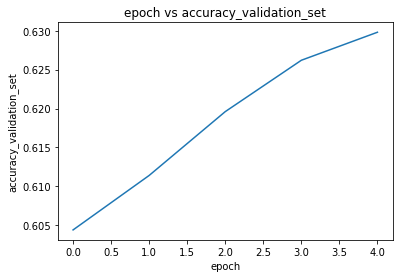

In [24]:
plot_accuracy(out_lst)

# Train vs Validation loss

In [25]:
def overfit_check(out_lst):
  plt.plot([a['val_loss'] for a in out_lst])
  plt.plot([a['train_loss'] for a in out_lst])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['val_loss', 'train_loss'])
  plt.title('check_overfiting_train_val_loss')

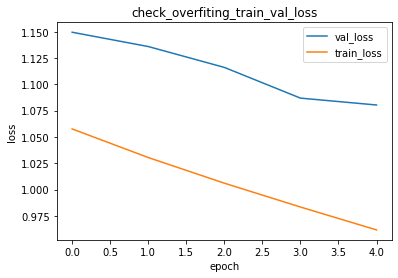

In [26]:
overfit_check(out_lst)

# Prediction on the test images

In [27]:
def pred_function(img,model,classes):
  img = img.unsqueeze(0).to(device)
  output = model(img)
  prob,pred = torch.max(output,dim=1)
  return pred.item(), classes[pred]

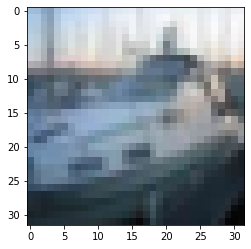

Label: 8 , Predicted: ship


In [32]:
img,label = test_dataset[2]
imshow(test_dataset[2])
pred = pred_function(img,model,classes)
print('Label:', pred[0], ', Predicted:', pred[1])

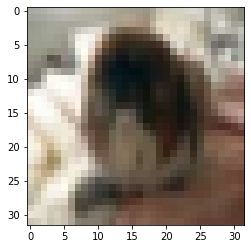

Label: 5 , Predicted: dog


In [33]:
img,label = test_dataset[200]
imshow(test_dataset[200])
pred = pred_function(img,model,classes)
print('Label:', pred[0], ', Predicted:', pred[1])

# Prediction on the entire test set

We can see that the accuracy on the entire test set is 68% which is not good

> In the next blog we will how we can achieve state of the art results using a resnet architecture

In [34]:
check_scores(test_loader,model)

{'val_loss': 1.0965526103973389, 'val_acc': 0.6254726052284241}